In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/B/b16.stp
/kaggle/input/B/b12.stp
/kaggle/input/B/b02.stp
/kaggle/input/B/b13.stp
/kaggle/input/B/b18.stp
/kaggle/input/B/b09.stp
/kaggle/input/B/b15.stp
/kaggle/input/B/b10.stp
/kaggle/input/B/b05.stp
/kaggle/input/B/b03.stp
/kaggle/input/B/b07.stp
/kaggle/input/B/b11.stp
/kaggle/input/B/b17.stp
/kaggle/input/B/b01.stp
/kaggle/input/B/b08.stp
/kaggle/input/B/b04.stp
/kaggle/input/B/b14.stp
/kaggle/input/B/b06.stp


# 数据源：[SteinLib Testdata Library Testset B](https://steinlib.zib.de/showset.php?B)

In [66]:
# 基本包导入
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from statistics import mean
from networkx.algorithms.approximation import steiner_tree

random.seed(42)

# 文件基本信息 Opt最佳解法

The column **DC** classifies the difficulty of the instance.

**L**
+ Solvable by usage of local preprocessing. Typical examples are the SD-Test, BD-n Tests and FST computations. Neither a global upper nor lower bound needs to be computed.

**P**
+ Solvable by polynomial time algorithms, like dual ascent in combination with primal heuristic, a integral LP formulation or advanced preprocessing like reduced cost criteria or the RCR-Test.

**NP**
+ No polynomial time algorithm is known. Use of an exponential time enumeration sceme like Branch-and-Bound is neccessary.
+ The letter after class gives an impression how long it takes to solve the problem using state-of-the-art soft- and hardware. secounds means less than a minute (this includes instances which can be solved in fractions of a second). minutes means less than an hour. hours is less than a day and days is less than a week. weeks mean it takes really a long time to solve this instance. ? means the instance is not solved or the time is not known.

If the number in the **Opt** column is written in italics the optimum is not known. The number given is the best know upper bound.

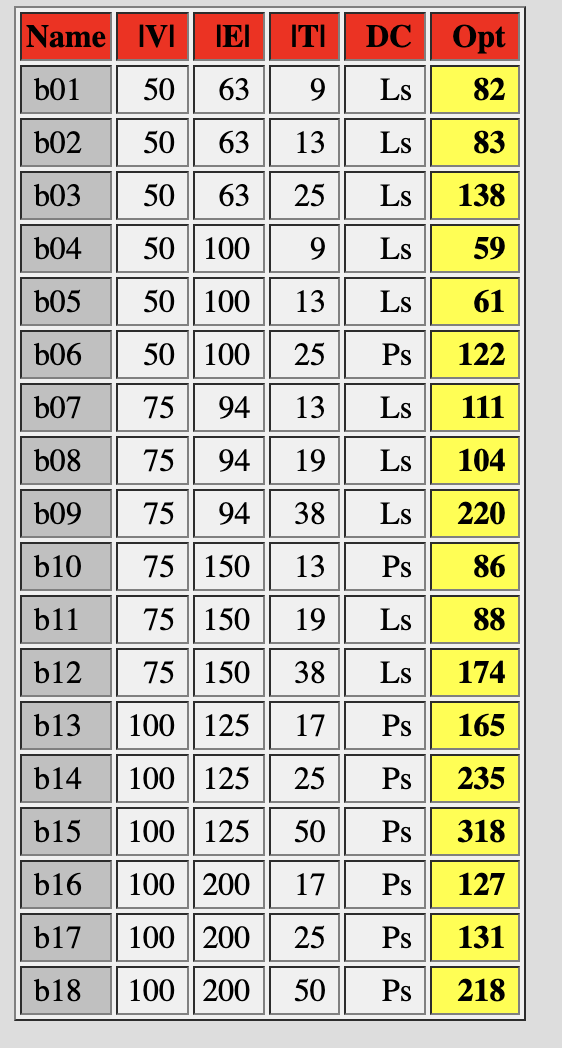

# 边的存储方案设计
1. 邻接矩阵
+ 优点：

      + 直接访问任意两个节点间的边权重。
      + 实现简单，直观。
+ 缺点：

      + 对于稀疏图，空间效率低（大多数空间存储的是无边的信息，如inf或0）。
      + 每次操作（如更新信息素）都需要遍历整个矩阵，效率可能不高。
      
2. 邻接列表
+ 优点：

    + 空间效率高，只存储实际存在的边。
    + 对于稀疏图，操作效率高。
+ 缺点：

    + 检查两个特定节点间是否存在边需要更多时间（需要遍历列表）。
    + 对于蚁群算法，更新信息素时可能需要更复杂的数据结构来快速访问和更新边的权重和信息素。
    
3. 边列表
+ 优点：

    + 简单，列出所有边及其属性（起点、终点、权重、信息素等）。
    + 对于加权无向图，这种结构简洁且易于管理。
+ 缺点：

    + 查找特定边或更新边的权重可能需要遍历整个列表。
    + 对于非常大的图，这种结构的效率可能不如邻接矩阵或邻接列表。
    
4. 哈希表结构（字典的字典）
+ 优点：

    + 结合了邻接矩阵和邻接列表的优点。
    + 快速检索任意两节点间的边信息。
    + 空间效率相对较高，特别适合稀疏图。
+ 缺点：

    + 相较于邻接矩阵和简单的邻接列表，实现稍微复杂。

In [5]:
'''
    基于哈希表的边存储
'''
def parse_stp(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    graph_info = {
        'nodes': set(),
        'edges': {},  
        'terminals': set()
    }

    initial_pheromone = 0.1  # 初始信息素的值
    in_section = None
    for line in lines:
        line = line.strip()
        if line.startswith('SECTION'):
            in_section = line.split()[1]
        elif line.startswith('END'):
            in_section = None
        elif in_section == 'Graph':
            if line.startswith('Nodes'):
                num_nodes = int(line.split()[1])
            elif line.startswith('Edges'):
                num_edges = int(line.split()[1])
            elif line.startswith('E'):
                _, start, end, weight = line.split()
                start, end, weight = int(start), int(end), int(weight)
                graph_info['nodes'].update([start, end])
                
                if start not in graph_info['edges']:
                    graph_info['edges'][start] = {}
                graph_info['edges'][start][end] = {'weight': weight, 'pheromone': initial_pheromone}
                
                # 如果是无向图，也添加反向边
                if end not in graph_info['edges']:
                    graph_info['edges'][end] = {}
                graph_info['edges'][end][start] = {'weight': weight, 'pheromone': initial_pheromone}
                
        elif in_section == 'Terminals':
            if line.startswith('Terminals'):
                num_terminals = int(line.split()[1])
            elif line.startswith('T'):
                _, term = line.split()
                graph_info['terminals'].add(int(term))
    
    return graph_info

def process_all_stp_files(directory):
    stp_files = sorted(
        [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.stp')],
        key=lambda x: x.lower()  # 这会确保文件名的排序不受大小写影响
    )
    print(stp_files)

    graphs_info = []
    for stp_file in stp_files:
        graph_info = parse_stp(stp_file)
        graphs_info.append(graph_info)
        print(f"Processed {stp_file}:")
        print(f"  Nodes: {len(graph_info['nodes'])}")
        print(f"  Edges: {sum(len(v) for v in graph_info['edges'].values()) // 2}")  # Divided by 2 because each edge is stored twice
        print(f"  Terminals: {len(graph_info['terminals'])}")
    
    return graphs_info


In [6]:
# 设置文件夹路径
directory = '/kaggle/input/B'
all_graphs_info = process_all_stp_files(directory)
best_solutions = [82, 83, 138, 59, 61, 122, 111, 104, 220, 86, 88, 174, 165, 235, 318, 127, 131, 218]

['/kaggle/input/B/b01.stp', '/kaggle/input/B/b02.stp', '/kaggle/input/B/b03.stp', '/kaggle/input/B/b04.stp', '/kaggle/input/B/b05.stp', '/kaggle/input/B/b06.stp', '/kaggle/input/B/b07.stp', '/kaggle/input/B/b08.stp', '/kaggle/input/B/b09.stp', '/kaggle/input/B/b10.stp', '/kaggle/input/B/b11.stp', '/kaggle/input/B/b12.stp', '/kaggle/input/B/b13.stp', '/kaggle/input/B/b14.stp', '/kaggle/input/B/b15.stp', '/kaggle/input/B/b16.stp', '/kaggle/input/B/b17.stp', '/kaggle/input/B/b18.stp']
Processed /kaggle/input/B/b01.stp:
  Nodes: 50
  Edges: 63
  Terminals: 9
Processed /kaggle/input/B/b02.stp:
  Nodes: 50
  Edges: 63
  Terminals: 13
Processed /kaggle/input/B/b03.stp:
  Nodes: 50
  Edges: 63
  Terminals: 25
Processed /kaggle/input/B/b04.stp:
  Nodes: 50
  Edges: 100
  Terminals: 9
Processed /kaggle/input/B/b05.stp:
  Nodes: 50
  Edges: 100
  Terminals: 13
Processed /kaggle/input/B/b06.stp:
  Nodes: 50
  Edges: 100
  Terminals: 25
Processed /kaggle/input/B/b07.stp:
  Nodes: 75
  Edges: 94
  T

# 图可视化

In [7]:
def visualize_graph(graph_info, layout='spring'):
    G = nx.Graph()
    
    # 添加节点
    G.add_nodes_from(graph_info['nodes'])
    
    # 添加边，使用字典的字典提取边和权重
    for start, connections in graph_info['edges'].items():
        for end, attributes in connections.items():
            G.add_edge(start, end, weight=attributes['weight'], pheromone=attributes['pheromone'])

    # 选择布局算法
    pos = {
        'spring': nx.spring_layout(G),
        'circular': nx.circular_layout(G),
        'kamada_kawai': nx.kamada_kawai_layout(G),
        'shell': nx.shell_layout(G)
    }.get(layout, nx.spring_layout(G))

    # 绘制网络图
    plt.figure(figsize=(12, 12))  # 设置图形的大小
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', linewidths=1, font_size=15)

    # 绘制边的权重
    edge_weights = {(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_color='green')

    # 显示图形
    plt.title('Graph Visualization')
    plt.show()

In [8]:
print(all_graphs_info[0])

{'nodes': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}, 'edges': {2: {8: {'weight': 8, 'pheromone': 0.1}, 21: {'weight': 7, 'pheromone': 0.1}, 32: {'weight': 2, 'pheromone': 0.1}, 19: {'weight': 5, 'pheromone': 0.1}, 36: {'weight': 8, 'pheromone': 0.1}}, 8: {2: {'weight': 8, 'pheromone': 0.1}}, 21: {2: {'weight': 7, 'pheromone': 0.1}, 12: {'weight': 7, 'pheromone': 0.1}, 17: {'weight': 5, 'pheromone': 0.1}, 18: {'weight': 10, 'pheromone': 0.1}, 22: {'weight': 2, 'pheromone': 0.1}}, 32: {2: {'weight': 2, 'pheromone': 0.1}}, 4: {5: {'weight': 8, 'pheromone': 0.1}, 36: {'weight': 6, 'pheromone': 0.1}}, 5: {4: {'weight': 8, 'pheromone': 0.1}, 28: {'weight': 8, 'pheromone': 0.1}, 30: {'weight': 4, 'pheromone': 0.1}}, 7: {29: {'weight': 7, 'pheromone': 0.1}, 20: {'weight': 3, 'pheromone': 0.1}}, 29: {7: {'weight': 7, 'pheromone': 0.1}, 9: {'weight

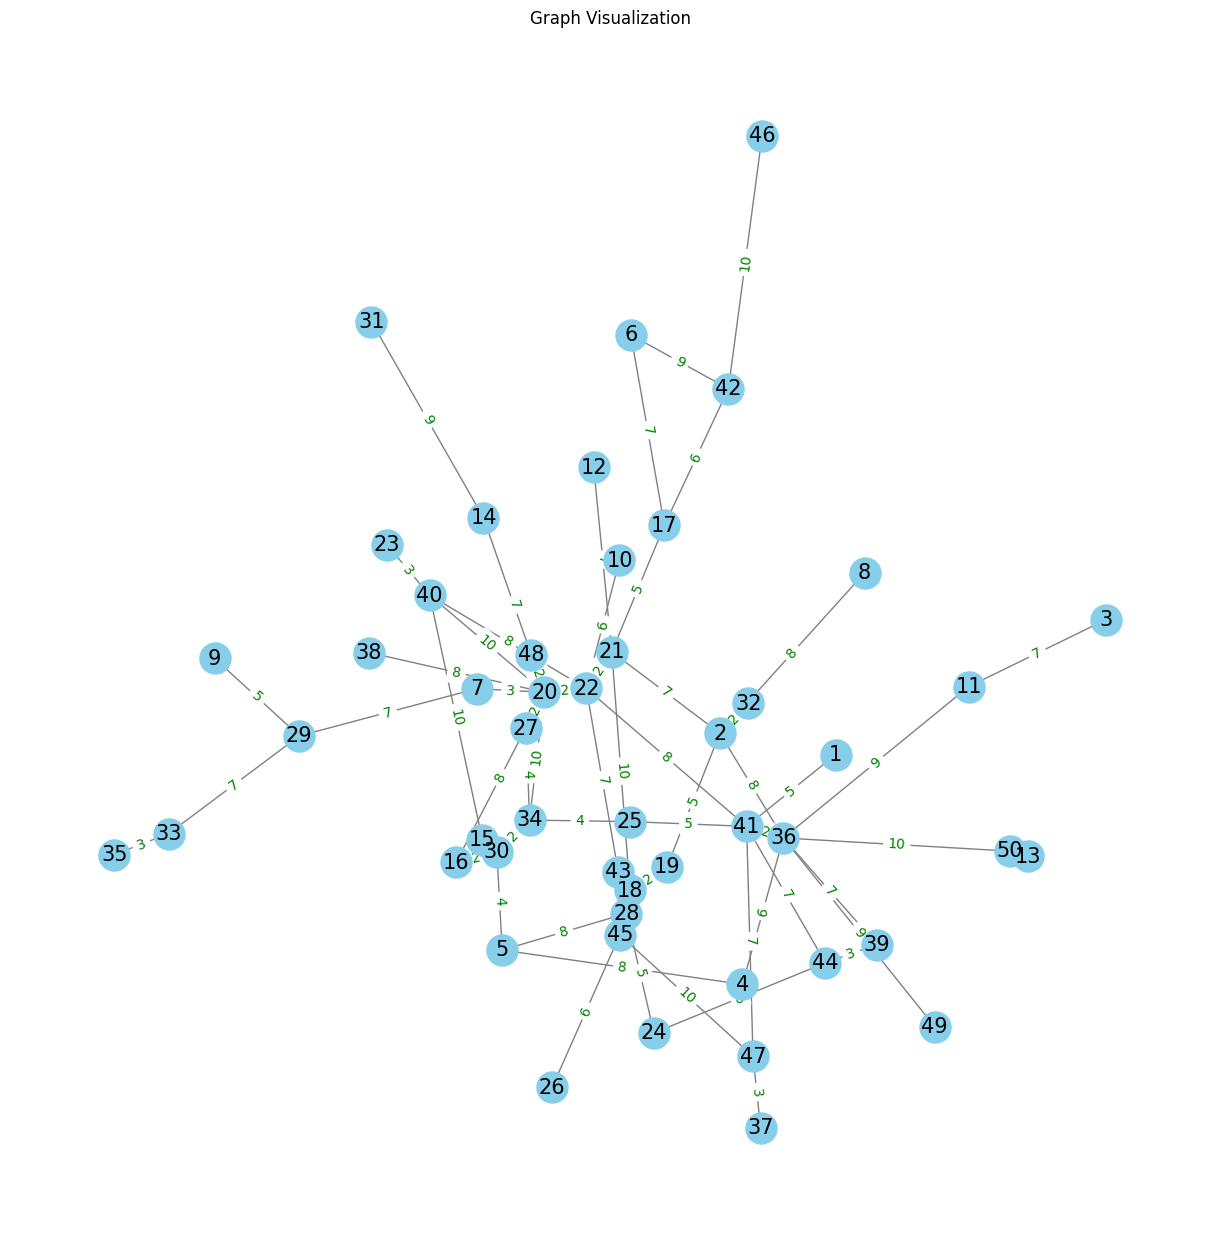

In [9]:
visualize_graph(all_graphs_info[0], layout='kamada_kawai')

# Ant Colony Optimization 蚂蚁算法

# Ant Colony Optimizer (ACO) Algorithm Documentation

## 1. 算法概述

蚁群优化算法(Ant Colony Optimization, ACO)是一种用于解决组合优化问题的概率技术。它受到蚂蚁在寻找食物路径时的行为启发。在这个实现中,ACO被用来解决一个特殊的图论问题,目标是找到一条覆盖所有终端节点的最短路径。

## 2. 初始化

### 2.1 参数初始化

- `num_ants`: 蚂蚁数量
- `iterations`: 迭代次数
- `decay`: 信息素衰减率
- `alpha`: 信息素重要性因子
- `beta`: 启发式信息重要性因子
- `Q`: 信息素增强常量
- `must_contain_all_terminals`: 是否必须包含所有终端节点

### 2.2 信息素初始化

对于图中的每条边(i,j),初始化信息素浓度:

$τ_{ij}(0) = 0.1$

## 3. 主要迭代过程

对于每次迭代t = 1,2,...,iterations:

### 3.1 路径构建

对于每只蚂蚁k = 1,2,...,num_ants:

1. 从一个随机的终端节点开始
2. 重复选择下一个节点,直到所有终端节点都被访问或无法继续移动
3. 计算路径成本和惩罚

### 3.2 信息素更新

对于每条边(i,j),更新信息素:

$τ_{ij}(t+1) = (1-ρ)τ_{ij}(t) + Δτ_{ij}$

其中,ρ是信息素衰减率,Δτ_{ij}是信息素增量:
$$
Δτ_{ij} = ∑_{k=1}^{m} Δτ_{ij}^k
$$

$$
Δτ_{ij}^k = {
  \frac{Q} {(L_k + P_k)} * R_k, 如果蚂蚁k经过边(i,j) \\
  0, otherwise
}
$$

$L_k$是路径长度,$P_k$是惩罚值,$R_k$是奖励因子(基于覆盖的终端节点数量)

### 3.3 参数调整

基于终端节点的覆盖率调整α和β:

如果覆盖率 < 1.0:

  α = max(min(α * 0.9, 10), 0.1) 
  
  β = max(min(β * 1.1, 10), 0.1)
  
否则:

  α = max(min(α * 1.1, 10), 0.1)
  
  β = max(min(β * 0.9, 10), 0.1)
  

## 4. 节点选择策略

在每一步,蚂蚁k从节点i选择下一个节点j的概率为:

$$
p_{ij}^k = {
  \frac{[τ_{ij}]^α * [η_{ij}]^β * w_j} {∑_{l∈N_i^k} [τ_{il}]^α * [η_{il}]^β * w_l}, 如果j∈N_i^k \\
  0, otherwise
}
$$

其中:
$$
- τ_{ij}是边(i,j)上的信息素浓度 \\
- η_{ij}是启发式信息,通常为1/d_{ij},d_{ij}是边(i,j)的长度 \\
- N_i^k是蚂蚁k在节点i的可选择邻居集合 \\
- w_j是节点j的权重(如果j是终端节点,则为5.0,否则为1.0) \\
$$

## 5. 路径评估
$$
路径成本 = ∑_{(i,j)∈path} d_{ij} \\
惩罚 = 未覆盖终端节点数 * 惩罚系数 \\
总成本 = 路径成本 + 惩罚 \\
$$

## 6. 终止条件

算法在完成预定的迭代次数后终止,返回找到的最佳路径、其成本和惩罚值。

## 7. 特殊策略

### 7.1 强制路径到最近终端

当蚂蚁无法继续移动时,尝试强制移动到最近的未访问终端节点。

### 7.2 增强启发式

通过考虑路径特征(如避免立即重复或循环)来增强启发式信息。

In [33]:
class AntColonyOptimizer:
    def __init__(self, graph_info, num_ants=200, iterations=300, decay=0.1, alpha=1, beta=1, Q=100, must_contain_all_terminals=False):
        self.graph_info = graph_info
        self.num_ants = num_ants
        self.iterations = iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.must_contain_all_terminals = must_contain_all_terminals
        self.Q = Q  # 信息素增强常量

    def initialize_pheromones(self):
        for node, connections in self.graph_info['edges'].items():
            for connected_node in connections:
                self.graph_info['edges'][node][connected_node]['pheromone'] = 0.1

    def run(self):
        self.initialize_pheromones()
        best_cost = float('inf')
        best_path = None
        best_penalty = 0

        for i in range(self.iterations):
            paths = []
            for j in range(self.num_ants):
                start_node = list(self.graph_info['terminals'])[j % len(self.graph_info['terminals'])]
                path, cost, penalty = self.construct_path(start_node)
                paths.append((path, cost, penalty))

            self.update_pheromones(paths)

            # 计算覆盖终端节点的比例
            coverage_set = set()
            for path, cost, penalty in paths:
                coverage_set.update(path)
            coverage_ratio = len(coverage_set & self.graph_info['terminals']) / len(self.graph_info['terminals'])

            # 根据覆盖率调整参数
            self.adjust_parameters(coverage_ratio)

            # 更新最佳路径和成本
            for path, cost, penalty in paths:
                new_cost = cost + penalty
                if new_cost < best_cost:
                    best_cost = new_cost
                    best_path = path
                    best_penalty = penalty

        return best_path, best_cost, best_penalty


    def construct_path(self, start_node):
        path = [start_node]
        current_node = start_node
        visited = set(path)
        remaining_terminals = self.graph_info['terminals'] - visited

        while remaining_terminals:
            next_node = self.choose_next_node(current_node, visited, remaining_terminals, path)
            if next_node is None:
                # Attempt to force a path to the nearest remaining terminal
                next_node = self.nearest_terminal(current_node, remaining_terminals)
                if next_node is None:
                    break
            path.append(next_node)
            visited.add(next_node)
            current_node = next_node
            if next_node in remaining_terminals:
                remaining_terminals.remove(next_node)

        cost, penalty = self.path_cost(path)
        return path, cost, penalty

    def nearest_terminal(self, current_node, remaining_terminals):
        # Implement logic to find the nearest terminal that hasn't been visited
        nearest = None
        min_dist = float('inf')
        for terminal in remaining_terminals:
            if terminal in self.graph_info['edges'][current_node]:
                dist = self.graph_info['edges'][current_node][terminal]['weight']
                if dist < min_dist:
                    nearest = terminal
                    min_dist = dist
        return nearest



    def choose_next_node(self, current_node, visited, remaining_terminals, path):
        connections = self.graph_info['edges'].get(current_node, {})
        filtered_connections = {k: v for k, v in connections.items() if k not in visited}  # Exclude visited nodes

        if not filtered_connections:
            return None

        # Adding extra heuristic weight to terminal nodes
        terminal_weights = {node: 5.0 if node in remaining_terminals else 1.0 for node in filtered_connections}

        # Enhance heuristic based on path characteristics
        # For instance, discourage selections that lead to immediate repetitions or cycles
        enhanced_heuristic = {
            node: (1 / attr['weight']) * (0.8 if (len(path) > 2 and node == path[-2]) else 1.0)
            for node, attr in filtered_connections.items()
        }

        # Calculate total for probabilistic decision making
        total = sum((attr['pheromone'] ** self.alpha) * enhanced_heuristic[node] * terminal_weights[node]
                    for node, attr in filtered_connections.items())

        # Calculate probabilities for each connection
        probabilities = [(attr['pheromone'] ** self.alpha) * enhanced_heuristic[node] * terminal_weights[node] / total
                         for node, attr in filtered_connections.items()]

        # Select next node based on the calculated probabilities
        next_node_candidates = list(filtered_connections.keys())
        next_node = random.choices(next_node_candidates, weights=probabilities, k=1)[0]

        return next_node


    def update_pheromones(self, paths):
        for path, cost, penalty in paths:
            if cost < float('inf'):  # Ensure the path is feasible
                covered_terminals = set(path) & self.graph_info['terminals']
                reward_factor = len(covered_terminals) / len(self.graph_info['terminals'])
                for i in range(len(path) - 1):
                    start, end = path[i], path[i + 1]
                    self.graph_info['edges'][start][end]['pheromone'] += self.Q / (cost + penalty) * reward_factor
                for node, connections in self.graph_info['edges'].items():
                    for connected_node in connections:
                        connections[connected_node]['pheromone'] *= (1 - self.decay)



    def path_cost(self, path):
        missing_terminals = set(self.graph_info['terminals']) - set(path)
        if self.must_contain_all_terminals and missing_terminals:
            return float('inf'), float('inf')  # Invalidate paths not covering all terminals
        penalty_per_terminal = 1000
        penalty = penalty_per_terminal * len(missing_terminals)
        cost = sum(self.graph_info['edges'][path[i]][path[i + 1]]['weight'] for i in range(len(path) - 1))
        return cost, penalty

    
    def adjust_parameters(self, coverage_ratio):
        # Adjust parameters based on the ratio of terminals covered in the last iteration
        # Setting boundrary values in case range overflow
        if coverage_ratio < 1.0:
            self.alpha = max(min(self.alpha * 0.9, 10), 0.1)
            self.beta = max(min(self.beta * 1.1, 10), 0.1)
        else:
            self.alpha = max(min(self.alpha * 1.1, 10), 0.1)
            self.beta = max(min(self.beta * 0.9, 10), 0.1)

In [51]:
def validate_aco(all_graphs_info, best_solutions, start=0, end=len(all_graphs_info) - 1):
    all_costs = []
    all_trees = []
    times = []
    for index in range (start, end+1):
        start_time = time.time()
        improved_aco = AntColonyOptimizer(all_graphs_info[index])
        best_tree, best_cost, best_penalty = improved_aco.run()
        end_time = time.time()
        time_used = end_time - start_time
        print(f"--------------------file b{index+1} finished, used {time_used}s -------------------------")
        uncovered = [x for x in list(all_graphs_info[index]['terminals']) if x not in best_tree]
        print(f"Best Steiner tree cost: {best_cost - best_penalty}")
        print(f"Known best cost {best_solutions[index]}")
        print(f"Uncovered nodes size: {len(uncovered)}")
        print(f"Uncovered nodes: {uncovered}")
        all_costs.append(best_cost)
        all_trees.append(best_tree)
        times.append(time_used)
    ratios = [a / b for a, b in zip(all_costs, best_solutions[start:end+1])]
    average_ratio = mean(ratios)
    print(f"average approximation: {average_ratio}")
    return times, ratios, all_costs, all_trees

In [52]:
aco_times, aco_ratios, aco_all_costs, acoall_trees = validate_aco(all_graphs_info, best_solutions)

--------------------file b1 finished, used 8.295977115631104s -------------------------
Best Steiner tree cost: 83
Known best cost 82
Uncovered nodes size: 3
Uncovered nodes: [35, 37, 49]
--------------------file b2 finished, used 6.451099872589111s -------------------------
Best Steiner tree cost: 48
Known best cost 83
Uncovered nodes size: 6
Uncovered nodes: [6, 41, 49, 19, 23, 25]
--------------------file b3 finished, used 13.099541664123535s -------------------------
Best Steiner tree cost: 96
Known best cost 138
Uncovered nodes size: 9
Uncovered nodes: [2, 15, 16, 20, 25, 28, 32, 38, 44]
--------------------file b4 finished, used 20.727952003479004s -------------------------
Best Steiner tree cost: 117
Known best cost 59
Uncovered nodes size: 0
Uncovered nodes: []
--------------------file b5 finished, used 16.392072439193726s -------------------------
Best Steiner tree cost: 107
Known best cost 61
Uncovered nodes size: 0
Uncovered nodes: []
--------------------file b6 finished, us

# Improved Colony Optimization 优化蚂蚁算法

## 1. 主要优化点

### 1.1 图的预处理

新算法引入了 `preprocess_graph` 方法，使用 NetworkX 库构建图结构，并预计算所有节点对之间的最短路径。这显著提高了后续路径构建的效率。

数学表示：

- G = (V, E)，其中 V 是节点集，E 是边集
- ∀u,v ∈ V, 计算 shortest_path(u, v)

### 1.2 蚂蚁数量动态调整

新算法将蚂蚁数量设置为终端节点数量的 3 倍

这确保了有足够的蚂蚁来探索解空间，同时避免了过多的计算开销。

### 1.3 改进的树构建策略

新算法在构建树时使用了更复杂的策略，考虑了路径的整体成本和信息素水平：

数学公式：
$$
D_{ij} = τ_{ij}^α * (1 / (C_{ij} + ε))^β
$$

其中：
$$
- D_{ij} 是边 (i,j) 的期望值 \\
- τ_{ij} 是边 (i,j) 上的信息素水平 \\
- C_{ij} 是边 (i,j) 的成本 \\
- ε 是一个小常数，防止除以零 \\
- α 和 β 是控制信息素重要性和启发式信息重要性的参数 \\
$$

### 1.4 树剪枝

新算法引入了 `prune_tree` 方法，移除不必要的叶子节点：

```python
def prune_tree(self, tree):
    while True:
        leaves = [node for node in tree.nodes if tree.degree(node) == 1 and node not in self.terminals]
        if not leaves:
            break
        for leaf in leaves:
            tree.remove_node(leaf)
    return tree
```

这确保了最终的树只包含必要的节点，减少了冗余。

### 1.5 改进的信息素更新

新算法在更新信息素时考虑了树的总成本：

```python
deposit = self.Q / cost
for u, v in tree.edges:
    self.pheromone_matrix[u, v] += deposit
    self.pheromone_matrix[v, u] += deposit
```

数学公式：
$$
τ_{ij}(t+1) = (1-ρ)τ_{ij}(t) + Q / C_T
$$

其中：
$$
- ρ 是信息素衰减率 \\
- Q 是一个常数 \\
- C_T 是树 T 的总成本 \\
$$

## 2. 性能改进

1. **预计算最短路径**：通过预先计算所有节点对之间的最短路径，大大减少了运行时的计算量。

2. **高效的数据结构**：使用 NumPy 数组存储信息素矩阵，提高了访问和更新效率。

3. **智能的树构建**：新算法在构建树时考虑了全局信息（最短路径），而不是仅仅考虑相邻节点。

4. **适应性强的参数设置**：蚂蚁数量根据问题规模动态调整，α 和 β 参数可以更好地平衡探索和利用。

## 3. 局限性和潜在改进

1. **内存消耗**：预计算所有节点对的最短路径可能在大规模图中消耗大量内存。

2. **参数敏感性**：算法的性能可能对 α、β、Q 和 decay 参数敏感，可能需要针对特定问题进行调优。

3. **局部最优**：尽管有所改进，但算法仍可能陷入局部最优解。可以考虑引入扰动机制或与其他元启发式算法结合。

4. **并行化潜力**：当前实现是顺序的，可以考虑并行化以进一步提高性能。

In [22]:
class ImprovedAntColonyOptimizer:
    def __init__(self, graph_info, iterations=10, decay=0.1, alpha=1, beta=2, Q=100, output_progress=True):
        self.graph_info = graph_info
        self.num_ants = 3 * len(graph_info['terminals'])
        self.iterations = iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.output_progress = output_progress
        self.preprocess_graph()
    
    def preprocess_graph(self):
        self.graph = nx.Graph()
        for node, connections in self.graph_info['edges'].items():
            for connected_node, attr in connections.items():
                self.graph.add_edge(int(node), int(connected_node), weight=attr['weight'])
        
        n = max(self.graph.nodes) + 1
        self.pheromone_matrix = np.full((n, n), 0.1)
        self.terminals = set(self.graph_info['terminals'])
        self.steiner_nodes = set(self.graph.nodes) - self.terminals
        self.all_pairs_shortest_paths = dict(nx.all_pairs_dijkstra_path(self.graph, weight='weight'))

    def run(self):
        best_tree = None
        best_cost = float('inf')
        start = time.time()

        for i in range(self.iterations):
            trees = []
            for _ in range(self.num_ants):
                tree = self.construct_tree()
                if tree is not None:
                    trees.append(tree)
            
            self.update_pheromones(trees)
            
            for tree in trees:
                cost = self.tree_cost(tree)
                if cost < best_cost:
                    best_cost = cost
                    best_tree = tree
            
            if self.output_progress :
                print(f' iteration {i} finished, using {time.time() - start}s, best cost {best_cost}')
                start = time.time()
        return best_tree, best_cost

    def construct_tree(self):
        tree = nx.Graph()
        unconnected = set(self.terminals)
        start = random.choice(list(unconnected))
        tree.add_node(start)
        unconnected.remove(start)

        while unconnected:
            best_edge = None
            best_desirability = float('-inf')
            for u in tree.nodes:
                for v in unconnected:
                    path = self.all_pairs_shortest_paths[u][v]
                    cost = sum(self.graph[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))
                    pheromone = sum(self.pheromone_matrix[path[i], path[i+1]] for i in range(len(path)-1))
                    edge_desirability = (pheromone ** self.alpha) * ((1 / (cost + 1e-10)) ** self.beta)
                    if edge_desirability > best_desirability:
                        best_desirability = edge_desirability
                        best_edge = path

            if best_edge:
                for i in range(len(best_edge) - 1):
                    tree.add_edge(best_edge[i], best_edge[i+1], weight=self.graph[best_edge[i]][best_edge[i+1]]['weight'])
                unconnected.remove(best_edge[-1])
            else:
                # 如果找不到更好的边，随机选择一条路径连接未连接的终端节点
                u = random.choice(list(tree.nodes))
                v = random.choice(list(unconnected))
                path = self.all_pairs_shortest_paths[u][v]
                for i in range(len(path) - 1):
                    tree.add_edge(path[i], path[i+1], weight=self.graph[path[i]][path[i+1]]['weight'])
                unconnected.remove(v)

        return self.prune_tree(tree)

    def prune_tree(self, tree):
        while True:
            leaves = [node for node in tree.nodes if tree.degree(node) == 1 and node not in self.terminals]
            if not leaves:
                break
            for leaf in leaves:
                tree.remove_node(leaf)
        return tree

    def tree_cost(self, tree):
        return sum(tree[u][v]['weight'] for u, v in tree.edges)

    def update_pheromones(self, trees):
        self.pheromone_matrix *= (1 - self.decay)
        for tree in trees:
            cost = self.tree_cost(tree)
            if cost > 0:
                deposit = self.Q / cost
                for u, v in tree.edges:
                    self.pheromone_matrix[u, v] += deposit
                    self.pheromone_matrix[v, u] += deposit

In [26]:
def validate_improved_aco(all_graphs_info, best_solutions, start=0, end=len(all_graphs_info) - 1, output_progress=True):
    all_costs = []
    all_trees = []
    times = []
    for index in range (start, end+1):
        start_time = time.time()
        improved_aco = ImprovedAntColonyOptimizer(all_graphs_info[index], output_progress=output_progress)
        best_tree, best_cost = improved_aco.run()
        end_time = time.time()
        time_used = end_time - start_time
        print(f"--------------------file b{index+1} finished, used {time_used}s -------------------------")
        uncovered = [x for x in list(all_graphs_info[index]['terminals']) if x not in list(best_tree.nodes)]
        print(f"Best Steiner tree cost: {best_cost}")
        print(f"Known best cost {best_solutions[index]}")
        print(f"Steiner tree edges: {list(best_tree.nodes)}")
        print(f"Steiner tree edges: {list(best_tree.edges)}")
        print(f"Uncovered nodes size: {len(uncovered)}")
        print(f"Uncovered nodes: {uncovered}")
        all_costs.append(best_cost)
        all_trees.append(best_tree)
        times.append(time_used)
    ratios = [a / b for a, b in zip(all_costs, best_solutions[start:end+1])]
    average_ratio = mean(ratios)
    print(f"average approximation: {average_ratio}")
    return times, ratios, all_costs, all_trees

In [27]:
iaco_times, iaco_ratios, iaco_all_costs, iacoall_trees = validate_improved_aco(all_graphs_info, best_solutions, output_progress=False)

--------------------file b1 finished, used 0.6265614032745361s -------------------------
Best Steiner tree cost: 83
Known best cost 82
Steiner tree edges: [49, 36, 41, 25, 34, 27, 20, 48, 22, 21, 12, 47, 37, 43, 18, 28, 24, 7, 29, 33, 35]
Steiner tree edges: [(49, 36), (36, 41), (41, 25), (41, 47), (25, 34), (34, 27), (27, 20), (20, 48), (20, 22), (20, 7), (22, 21), (22, 43), (21, 12), (47, 37), (43, 18), (18, 28), (28, 24), (7, 29), (29, 33), (33, 35)]
Uncovered nodes size: 0
Uncovered nodes: []
--------------------file b2 finished, used 2.0381112098693848s -------------------------
Best Steiner tree cost: 85
Known best cost 83
Steiner tree edges: [43, 44, 11, 27, 35, 7, 39, 41, 9, 28, 40, 37, 45, 47, 25, 20, 36, 19, 29, 6, 31, 26, 49, 23]
Steiner tree edges: [(43, 44), (43, 27), (43, 28), (44, 11), (27, 35), (27, 9), (27, 29), (35, 7), (35, 41), (7, 39), (28, 40), (40, 37), (40, 31), (37, 45), (45, 47), (45, 20), (47, 25), (20, 36), (36, 19), (29, 6), (31, 26), (26, 49), (49, 23)]
Un

# NetworkX Steiner Tree

# Steiner Tree Approximation Algorithm Documentation

## 1. 概述

这个算法集合主要用于处理Steiner树问题，包括从STP（Steiner Tree Problem）文件格式读取图数据、将其转换为NetworkX图结构，以及使用近似算法求解Steiner树。

## 2. 函数说明

### 2.1 stp_2_nxGraph(filename)

#### 功能
从STP文件格式读取图数据，并转换为NetworkX图结构。

#### 参数
- `filename`: STP文件的路径

#### 返回值
- `G`: NetworkX图对象
- `terminals`: 终端节点集合

#### 算法步骤
1. 创建一个空的NetworkX图对象和终端节点集合。
2. 读取STP文件，解析其中的"Graph"和"Terminals"部分。
3. 在"Graph"部分，将边和权重添加到图中。
4. 在"Terminals"部分，将终端节点添加到终端集合中。
5. 返回构建的图和终端节点集合。

### 2.2 process_all_stp_files_2_nxGraph(directory)

#### 功能
处理指定目录下的所有STP文件，将它们转换为NetworkX图结构。

#### 参数
- `directory`: 包含STP文件的目录路径

#### 返回值
- `graphs_info`: 包含所有图信息的列表
- `terminals`: 包含所有终端节点集合的列表

#### 算法步骤
1. 获取目录中所有的STP文件，并按文件名排序。
2. 对每个STP文件调用`stp_2_nxGraph`函数。
3. 收集所有图信息和终端节点集合。
4. 返回收集到的图信息和终端节点集合列表。

### 2.3 approximate_steiner_tree(graph, terminals)

#### 功能
使用NetworkX的steiner_tree函数近似计算Steiner树，并计算其总成本。

#### 参数
- `graph`: NetworkX图对象
- `terminals`: 终端节点集合

#### 返回值
- `st_tree`: 近似的Steiner树（NetworkX图对象）
- `total_cost`: Steiner树的总成本

#### 算法步骤
1. 使用NetworkX的steiner_tree函数计算近似Steiner树。
2. 计算得到的Steiner树的总成本（所有边权重之和）。
3. 返回Steiner树和总成本。

In [84]:
def stp_2_nxGraph(filename):
    import networkx as nx
    G = nx.Graph()
    terminals = set()
    current_section = None
    
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if not line or line.startswith('#'):  # Skip empty lines and comments
                continue
            if line.startswith('SECTION'):
                current_section = line.split()[1]
            elif line == 'END':
                current_section = None
            elif current_section == 'Graph':
                if line.startswith('E'):
                    parts = line.split()
                    if len(parts) < 4:
#                         print(f"Skipping malformed line in Graph section: {line}")
                        continue
                    node1, node2, weight = parts[1], parts[2], float(parts[3])
                    G.add_edge(node1, node2, weight=weight)
            elif current_section == 'Terminals':
                if line.startswith('T'):
                    parts = line.split()
                    if len(parts) < 2:
#                         print(f"Skipping malformed line in Terminals section: {line}")
                        continue
                    terminal = parts[1]
                    terminals.add(terminal)
    
    return G, terminals

def process_all_stp_files_2_nxGraph(directory):
    stp_files = sorted(
        [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.stp')],
        key=lambda x: x.lower()  # 这会确保文件名的排序不受大小写影响
    )
    print(stp_files)

    graphs_info = []
    terminals = []
    for stp_file in stp_files:
        graph, terminal = stp_2_nxGraph(stp_file)
        graphs_info.append(graph)
        terminals.append(terminal)
    
    return graphs_info, terminals

In [85]:
def approximate_steiner_tree(graph, terminals):
    """
    Approximate the Steiner tree using NetworkX's steiner_tree function and calculate its total cost.
    """
    # Calculate the Steiner tree using the built-in approximation function
    # 指定方法为 'kou' 或 'mehlhorn'
    st_tree = steiner_tree(graph, terminals, weight='weight', method='kou')
    
    # Calculate the total cost of the Steiner tree
    total_cost = sum(data['weight'] for u, v, data in st_tree.edges(data=True))
    
    return st_tree, total_cost

In [86]:
def validate_nx_st_tree(directory, best_sols):
    nx_graphs_info, nx_terminals = process_all_stp_files_2_nxGraph(directory)
    nx_all_trees, nx_all_costs, uncovered_terminals_list = [], [], []
    
    index = 0
    for graph, terminals in zip(nx_graphs_info, nx_terminals):
        start = time.time()
        st_tree, cost = approximate_steiner_tree(graph, terminals)  # Using some approximation algorithm
        end = time.time()
        
        # Check which terminals are not covered by the Steiner tree
        covered_terminals = set(st_tree.nodes())
        uncovered_terminals = set(terminals) - covered_terminals
        
        print(f"--------------------file b{index+1} finished, used {end - start}s -------------------------")
        nx_all_trees.append(st_tree)
        nx_all_costs.append(cost)
        uncovered_terminals_list.append(uncovered_terminals)
        
        print("Total cost of the Steiner tree:", cost)
        print(f"Known best cost {best_solutions[index]}")
        print("Num of uncovered terminals:", len(uncovered_terminals))
        print("Uncovered terminals:", list(uncovered_terminals))
        index += 1
    
    ratios = [a / b for a, b in zip(nx_all_costs, best_sols)]
    average_ratio = sum(ratios) / len(ratios)
    print(f"average approximation: {average_ratio}")
    
    return ratios, nx_all_costs, nx_all_trees

In [88]:
nx_ratios, nx_all_costs, nx_all_trees = validate_nx_st_tree(directory, best_solutions)

['/kaggle/input/B/b01.stp', '/kaggle/input/B/b02.stp', '/kaggle/input/B/b03.stp', '/kaggle/input/B/b04.stp', '/kaggle/input/B/b05.stp', '/kaggle/input/B/b06.stp', '/kaggle/input/B/b07.stp', '/kaggle/input/B/b08.stp', '/kaggle/input/B/b09.stp', '/kaggle/input/B/b10.stp', '/kaggle/input/B/b11.stp', '/kaggle/input/B/b12.stp', '/kaggle/input/B/b13.stp', '/kaggle/input/B/b14.stp', '/kaggle/input/B/b15.stp', '/kaggle/input/B/b16.stp', '/kaggle/input/B/b17.stp', '/kaggle/input/B/b18.stp']
--------------------file b1 finished, used 0.018363475799560547s -------------------------
Total cost of the Steiner tree: 87.0
Known best cost 82
Num of uncovered terminals: 0
Uncovered terminals: []
--------------------file b2 finished, used 0.014858722686767578s -------------------------
Total cost of the Steiner tree: 100.0
Known best cost 83
Num of uncovered terminals: 0
Uncovered terminals: []
--------------------file b3 finished, used 0.015980243682861328s -------------------------
Total cost of the S